In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-detect-chatgpt-answers/sample_submission.csv
/kaggle/input/ml-olympiad-detect-chatgpt-answers/train.csv
/kaggle/input/ml-olympiad-detect-chatgpt-answers/test.csv


>**Hi all, this is the model design for chatgpt detection using capsule network. Although capsule networks are more used for image processing, they also have good performance in the task of text local information extraction**

# **First,we preproessing the data**

In [2]:
train=pd.read_csv("/kaggle/input/ml-olympiad-detect-chatgpt-answers/train.csv")
train=train.dropna().reset_index()
test=pd.read_csv("/kaggle/input/ml-olympiad-detect-chatgpt-answers/test.csv")
sub=pd.read_csv("/kaggle/input/ml-olympiad-detect-chatgpt-answers/sample_submission.csv")

In [3]:
train["text"]=train["prompt"]+train["answer"]
train=train[["text","AI"]]

In [4]:
test["text"]=test["prompt"]+test["answer"]
test=test["text"]

In [5]:
import re
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
import emoji
def dataPreprocessing(x):    
    x = x.lower()
    x = removeHTML(x)
    x = emoji.demojize(x, delimiters=(" ", " "))
    x = re.sub("@\w+", '',x) # removing mentions (@)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub(r"[^\w\s]", '',x) # to remove symbols
    x = re.sub("http\w+", '',x)
    x = re.sub("\s[a-z]\s", '',x)
    x = x.strip()
    return x
train_text=train["text"].apply(lambda x: dataPreprocessing(x))

In [6]:
test_text=test.apply(lambda x: dataPreprocessing(x))

# **Second,we import transformer to get the training vectors**

In [7]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

False
cpu


In [8]:
from torch import nn
from transformers import RobertaTokenizer, RobertaModel
from transformers import AdamW
from tqdm import tqdm
class BertClassificationModel(nn.Module):
    def __init__(self,hidden_size=768,num_class=2): 
        super(BertClassificationModel, self).__init__()
        model_name = "roberta-base"
        self.tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
        self.bert = RobertaModel.from_pretrained(pretrained_model_name_or_path=model_name)

        for p in self.bert.parameters(): 
                p.requires_grad = False
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, batch_sentences): 
        sentences_tokenizer = self.tokenizer(batch_sentences,
                                             truncation=True,
                                             padding=True,
                                             max_length=512,
                                             add_special_tokens=True)
        input_ids=torch.tensor(sentences_tokenizer['input_ids']).to(device) 
        attention_mask=torch.tensor(sentences_tokenizer['attention_mask']).to(device) 
        bert_out=self.bert(input_ids=input_ids,attention_mask=attention_mask) 

        last_hidden_state =bert_out[0].to(device) 
        bert_cls_hidden_state=last_hidden_state[:,0,:].to(device) 
        return bert_cls_hidden_state
model=BertClassificationModel()
model=model.to(device)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
xtrain=[]
for i in tqdm(train_text):
    xtrain.append(model([i]).cpu().detach().numpy())
xtrain=np.array(xtrain).reshape(-1,768)  
del train_text

100%|██████████| 746/746 [01:22<00:00,  9.08it/s]


In [10]:
xtest=[]
for i in tqdm(test_text):
    xtest.append(model([i]).cpu().detach().numpy())
xtest=np.array(xtest).reshape(-1,768)
del test_text

100%|██████████| 249/249 [00:26<00:00,  9.47it/s]


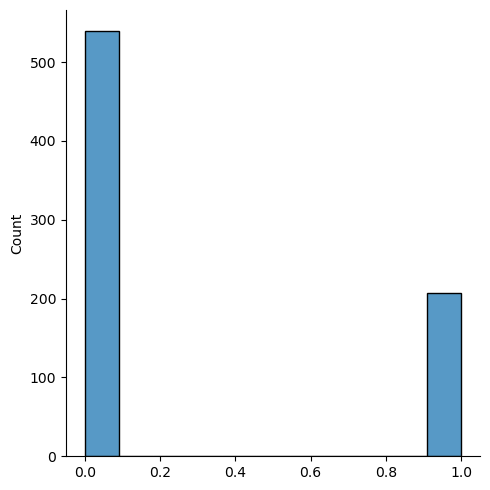

In [11]:
ytrain=train["AI"].values
import seaborn as sns
sns.displot(ytrain)

# **And now,we can establish the capsule network as follows**

In [12]:
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def squash(x, dim=-1):
    squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1 + squared_norm)
    scale=torch.tanh(squared_norm.sqrt())
    return scale * x / (squared_norm.sqrt() + 1e-8)

class PrimaryCaps1(nn.Module):
    def __init__(self, num_conv_units, in_channels, out_channels, kernel_size, stride):
        super(PrimaryCaps1, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels * num_conv_units,
                              kernel_size=kernel_size,
                              stride=stride)
        self.out_channels = out_channels

    def forward(self, x):
        out = self.conv(x)
        batch_size = out.shape[0]
        return squash(out.contiguous().view(batch_size, -1, self.out_channels), dim=-1)


class DigitCaps1(nn.Module):
    def __init__(self, in_dim, in_caps, out_caps, out_dim, num_routing):
        super(DigitCaps1, self).__init__()
        self.in_dim = in_dim
        self.in_caps = in_caps
        self.out_caps = out_caps
        self.out_dim = out_dim
        self.num_routing = num_routing
        self.device = device
        self.W = nn.Parameter(0.01 * torch.randn(1, out_caps, in_caps, out_dim, in_dim),
                              requires_grad=True)


    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1).unsqueeze(4)
        u_hat = torch.matmul(self.W, x) 
        u_hat = u_hat.squeeze(-1) 
        temp_u_hat = u_hat.detach()
        b = torch.zeros(batch_size, self.out_caps, self.in_caps, 1).to(self.device)
        for route_iter in range(self.num_routing - 1):
            c = b.softmax(dim=1)
            s = (c * temp_u_hat).sum(dim=2)
            v = squash(s)
            uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
            b += uv
        c = b.softmax(dim=1)
        s = (c * u_hat).sum(dim=2)
        v = squash(s)

        return v
class CapsNet1(nn.Module):
    def __init__(self):
        super(CapsNet1, self).__init__()

        self.conv = nn.Conv2d(2, 256, 9)
        self.relu = nn.ReLU(inplace=True)

        self.primary_caps = PrimaryCaps1(num_conv_units=32,
                                        in_channels=256,
                                        out_channels=8,
                                        kernel_size=8,
                                        stride=2)

        self.digit_caps = DigitCaps1(in_dim=8,
                                    in_caps=160,
                                    out_caps=2,
                                    out_dim=16,
                                    num_routing=3)

        self.decoder = nn.Sequential(
            nn.Linear(16 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 768),
            nn.Softmax())

    def forward(self, x):
        #x=x.cuda()
        out = self.relu(self.conv(x))
        out = self.primary_caps(out)
        out = self.digit_caps(out)
        logits = torch.norm(out, dim=-1)
        return logits

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import os
import pickle
import random
import itertools
def get_param_group(model):
    nd_list = []
    param_list = []
    for name, param in model.named_parameters():
        if 'ln' in name:
            nd_list.append(param)
        else:
            param_list.append(param)
    return [{'params': param_list, 'weight_decay': 1e-5}, {'params': nd_list, 'weight_decay': 0}]

# **What's more,we train it**

In [14]:
accs=[]
model=CapsNet1()#.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
max_f1=0
for ep in range(1200):
    correct=0
    total_loss=0
    for i in range(0, xtrain.shape[0], 1024):
        if i + 1024 > xtrain.shape[0]:
            x, y = xtrain[i:], ytrain[i:]
        else:
            x, y = xtrain[i:(i + 1024)], ytrain[i:(i + 1024)]
        x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True),Variable(torch.from_numpy(y))
        model.train()
        x=x.reshape(-1,2,24,16)
        optimizer.zero_grad()
        logits= model(x)
        pred = torch.argmax(logits, dim=1)
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        loss = criterion(logits, y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (ep + 1)%50==0:
        print('Train Epoch: {:2d}\t Loss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)\n '.format(ep + 1,total_loss,correct,xtrain.shape[0],100.* correct / xtrain.shape[0]))
    accs.append(100. * correct / x.shape[0])

Train Epoch: 50	 Loss: 0.590089	 Accuracy: 539/746 (72%)
 
Train Epoch: 100	 Loss: 0.570277	 Accuracy: 539/746 (72%)
 
Train Epoch: 150	 Loss: 0.529184	 Accuracy: 539/746 (72%)
 
Train Epoch: 200	 Loss: 0.515876	 Accuracy: 539/746 (72%)
 
Train Epoch: 250	 Loss: 0.492026	 Accuracy: 634/746 (85%)
 
Train Epoch: 300	 Loss: 0.457275	 Accuracy: 654/746 (88%)
 
Train Epoch: 350	 Loss: 0.448969	 Accuracy: 673/746 (90%)
 
Train Epoch: 400	 Loss: 0.438158	 Accuracy: 670/746 (90%)
 
Train Epoch: 450	 Loss: 0.428116	 Accuracy: 686/746 (92%)
 
Train Epoch: 500	 Loss: 0.425038	 Accuracy: 685/746 (92%)
 
Train Epoch: 550	 Loss: 0.420208	 Accuracy: 687/746 (92%)
 
Train Epoch: 600	 Loss: 0.408576	 Accuracy: 695/746 (93%)
 
Train Epoch: 650	 Loss: 0.410715	 Accuracy: 697/746 (93%)
 
Train Epoch: 700	 Loss: 0.405123	 Accuracy: 696/746 (93%)
 
Train Epoch: 750	 Loss: 0.426681	 Accuracy: 696/746 (93%)
 
Train Epoch: 800	 Loss: 0.413785	 Accuracy: 699/746 (94%)
 
Train Epoch: 850	 Loss: 0.408402	 Accurac

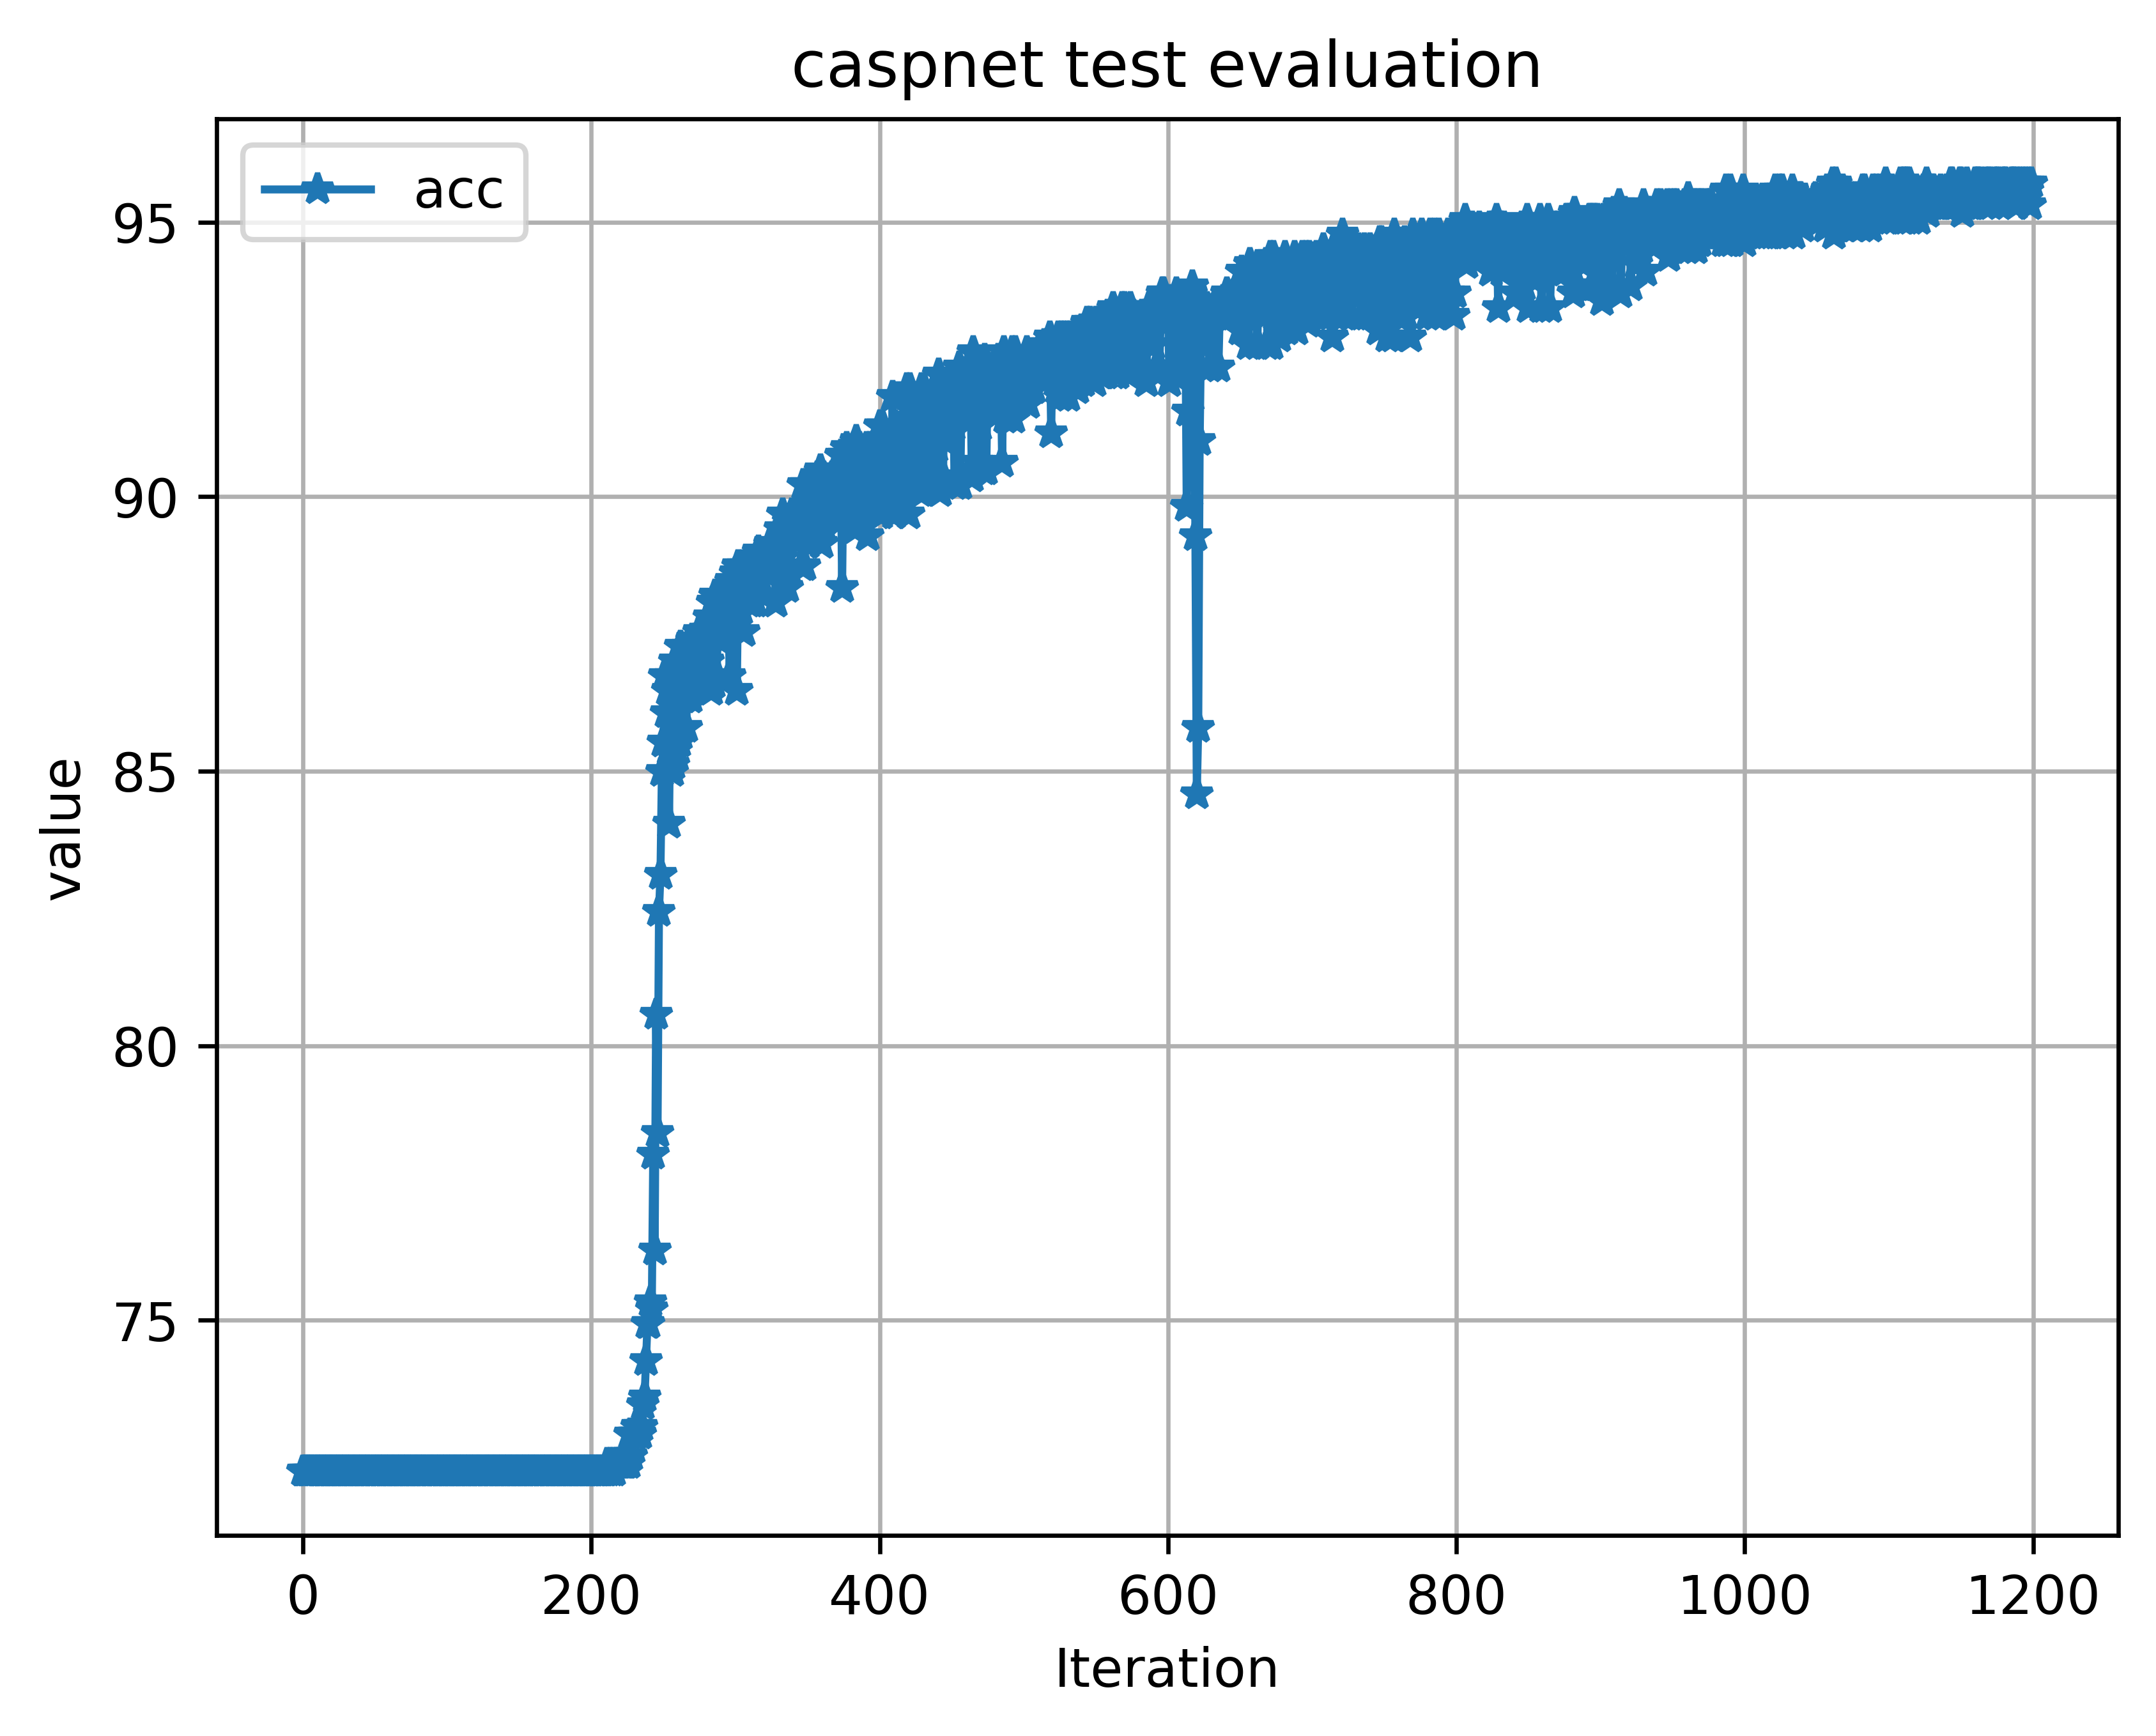

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams['axes.unicode_minus'] = False
plt.figure(dpi=600)
plt.plot(accs,'-*',label="acc")
plt.xlabel("Iteration",fontsize='medium')
plt.ylabel("value",fontsize='medium')
plt.grid()
plt.title("caspnet test evaluation")
plt.legend()
plt.show()

In [16]:
del xtrain
del x,y

# **Finally,we predict the answer**

In [17]:
xtest = Variable(torch.from_numpy(xtest).type(torch.float32), requires_grad=True)

In [18]:
xtest

tensor([[-0.0243,  0.0473, -0.0182,  ..., -0.1512, -0.0718,  0.0194],
        [-0.0393,  0.0829, -0.0414,  ..., -0.1243, -0.0500, -0.0273],
        [-0.0356,  0.0931, -0.0474,  ..., -0.1285, -0.0383, -0.0255],
        ...,
        [-0.0219,  0.0922, -0.0322,  ..., -0.1165, -0.0300, -0.0478],
        [-0.0608,  0.0436, -0.0045,  ..., -0.1377, -0.0633, -0.0426],
        [-0.0583,  0.1018, -0.0233,  ..., -0.0997, -0.0131, -0.0196]],
       requires_grad=True)

In [19]:
ypred2=[]
for i in tqdm(range(xtest.shape[0])):
    ypred2.append(model(xtest[i].reshape(-1,2,24,16)).cpu().detach().numpy()[0])
ypred2=np.array(ypred2).reshape(-1,2)
ypred2

100%|██████████| 249/249 [00:01<00:00, 243.15it/s]


array([[0.4658993 , 0.8954398 ],
       [0.99745405, 0.21965858],
       [0.32762077, 0.7958692 ],
       [0.31388763, 0.986263  ],
       [0.9590404 , 0.14101559],
       [0.9928218 , 0.08979924],
       [0.99721193, 0.02793233],
       [0.11546159, 0.9148597 ],
       [0.9419351 , 0.22574201],
       [0.9006981 , 0.5865174 ],
       [0.8257244 , 0.49050915],
       [0.3748218 , 0.83171034],
       [0.99510026, 0.06965098],
       [0.99422896, 0.00869594],
       [0.24767321, 0.9445238 ],
       [0.946316  , 0.2643582 ],
       [0.9896465 , 0.24313274],
       [0.6437238 , 0.5816478 ],
       [0.8289203 , 0.35430154],
       [0.6455796 , 0.65655625],
       [0.8953153 , 0.7179293 ],
       [0.98031276, 0.03272182],
       [0.99060965, 0.201127  ],
       [0.98337513, 0.09825279],
       [0.8838167 , 0.32124242],
       [0.9992695 , 0.16356021],
       [0.9910019 , 0.19801949],
       [0.9848206 , 0.2784326 ],
       [0.5830454 , 0.56244946],
       [0.99780643, 0.40381074],
       [0.

In [20]:
y=np.argmax(ypred2,axis=1)

In [21]:
sub["Category"]=y
sub

,Id,Category
0,710,1
1,487,0
2,136,1
3,44,1
4,627,0
...,...,...
244,702,0
245,500,0
246,818,0
247,584,0


In [22]:
sub.to_csv("sample_submission.csv",index=False)